# Introduction

## Purpose of this Notebook
This notebook shows a comparison between two Vector Databases, `Qdrant` and `Milvus` based on the benchmarking repository [vector-db-benchmark](https://github.com/qdrant/vector-db-benchmark).
- The main section contains a comparison of the two DataBases based on the benchmarking of some big datasets.
- Another section illustrates the performance differencies between filtered and regular vector search using the corresponding datasets with and without filters.

## Datasets
The datasets benchmarked for the comparison are listed here. They are a subset of [datasets.json](https://github.com/qdrant/vector-db-benchmark/blob/master/datasets/datasets.json)

**random-100-euclidean**
- Size: 218 KB
- vectors.jsonl , queries.jsonl , neighbours.jsonl
- distance: l2
  
**glove-25-angular**
- Size: 121 MB
- HDF5 file 
- distance: cosine

**glove-100-angular**
- Size: 462 MB
- HDF5 file
- distance: cosine
  
**random-match-keyword-100-angular-no-filters**
- Size: 404 MB
- vectors.npy , tests.jsonl
- distance: cosine

**random-match-keyword-100-angular-filters** 
- Size: 434 MB
- vectors.npy , tests.jsonl, payloads.jsonl
- distance: cosine

**h-and-m-2048-angular-no-filters**
- Size: 1.23 GB
- vectors.npy , tests.jsonl
- distance: cosine
  
**h-and-m-2048-angular-filters**
- Size: 1.29 GB
- vectors.npy , tests.jsonl , payloads.jsonl , filters.jsonl
- distance: cosine

**gist-960-euclidean** 
- Size: 3.58 GB
- HDF5 file
- distance: l2

**laion-small-clip**
- Size: 195 MB
- vectors.npy , tests.jsonl, payloads.jsonl
- distance: cosine

**dbpedia-openai-1M-1536-angular** 
- Size: 5.74 GB
- vectors.npy , tests.jsonl
- distance: cosine

**deep-image-96-angular**
- Size: 3.58 GB
- HDF5 file
- distance: cosine


In [1]:
tested_datasets = [
	# "random-100-euclidean", 
	# "glove-25-angular",
    "glove-100-angular",
	"random-match-keyword-100-angular-no-filters",
	# "random-match-keyword-100-angular-filters", 
	"h-and-m-2048-angular-no-filters",
	# "h-and-m-2048-angular-filters",
	"gist-960-euclidean",
	# "laion-small-clip",
	# "dbpedia-openai-1M-1536-angular",
    # "deep-image-96-angular"
]

fil_datasets = [
	# "random-match-keyword-100-angular-no-filters",
	# "random-match-keyword-100-angular-filters", 
	# "h-and-m-2048-angular-no-filters",
	# "h-and-m-2048-angular-filters",
]

## Results CSV Load

In [2]:
from IPython.display import display
import pandas as pd
from sqlite3 import connect
conn = connect(':memory:')

tested_upload_df = pd.read_csv("upload_results_24_Jan_2025.csv")
tested_search_df = pd.read_csv("search_results_24_Jan_2025.csv")

# drop unused dataset_size column
tested_upload_df = tested_upload_df.drop(columns=['dataset_size'])
tested_search_df = tested_search_df.drop(columns=['dataset_size'])
# add index time column for upload info
tested_upload_df['qdrant_index_time'] = ( tested_upload_df['qdrant_total_time'] - tested_upload_df['qdrant_upload_time'] )
tested_upload_df['milvus_index_time'] = ( tested_upload_df['milvus_total_time'] - tested_upload_df['milvus_upload_time'] )
# drop rows with ef_search = 64 (it is available only in Qdrant, not in Milvus)
tested_search_df = tested_search_df[tested_search_df["ef_search"] != 64]
# add a config column for search df
tested_search_df['config'] = (
    'm-' + tested_search_df['m'].astype(str) + 
    '-ef-' + tested_search_df['ef_construct'].astype(str) +
    '-parallel-' + tested_search_df['parallel_search'].astype(str) +
    '-ef-search-' + tested_search_df['ef_search'].astype(str)
)

# separate tables for Qdrant and Milvus
qdrant_upload_df = tested_upload_df.drop(columns=[col for col in tested_upload_df.columns if 'milvus' in col])
milvus_upload_df = tested_upload_df.drop(columns=[col for col in tested_upload_df.columns if 'qdrant' in col])
qdrant_search_df = tested_search_df.drop(columns=[col for col in tested_search_df.columns if 'milvus' in col])
milvus_search_df = tested_search_df.drop(columns=[col for col in tested_search_df.columns if 'qdrant' in col])

# add rounded mean precisions column for each DB and config description column
qdrant_search_df['mean_precisions_rounded'] = qdrant_search_df['qdrant_mean_precisions'].round(2)
milvus_search_df['mean_precisions_rounded'] = milvus_search_df['milvus_mean_precisions'].round(2)
# add database prefix in config
qdrant_search_df['config'] = 'qdrant-' + qdrant_search_df['config'].astype(str)
milvus_search_df['config'] = 'milvus-' + milvus_search_df['config'].astype(str)
# replace total_time with import_time
for df in [qdrant_upload_df, milvus_upload_df]:
    df.rename(columns={col: col.replace('total', 'import') for col in df.columns if 'total' in col},
            inplace=True
    )

# remove prefixes for the two DB dataframes
for prefix, df in [('qdrant_', qdrant_upload_df), ('qdrant_', qdrant_search_df), ('milvus_', milvus_upload_df), ('milvus_', milvus_search_df)]:
    df.rename(
        columns={col: col.replace(prefix, '') for col in df.columns if col.startswith(prefix)},
        inplace=True
    )
# merge the search dataframe with the upload to get upload and index time 
qdrant_search_df = pd.merge(
    qdrant_search_df,                  # Left DataFrame
    qdrant_upload_df,                  # Right DataFrame
    on=['m', 'ef_construct', 'dataset'],  # Keys
    how='inner',                       # Type of join
)
milvus_search_df = pd.merge(
    milvus_search_df,                  # Left DataFrame
    milvus_upload_df,                  # Right DataFrame
    on=['m', 'ef_construct', 'dataset'],  # Keys
    how='inner',                       # Type of join
)   

# Register as SQL tables
tested_upload_df.to_sql(name='tested_upload_df', con=conn)
tested_search_df.to_sql(name='tested_search_df', con=conn)

qdrant_upload_df.to_sql(name='qdrant_upload_df', con=conn)
milvus_upload_df.to_sql(name='milvus_upload_df', con=conn)
qdrant_search_df.to_sql(name='qdrant_search_df', con=conn)
milvus_search_df.to_sql(name='milvus_search_df', con=conn)

In [3]:
tested_upload_df.head(2)

,m,ef_construct,dataset,qdrant_upload_time,milvus_upload_time,qdrant_total_time,milvus_total_time,qdrant_index_time,milvus_index_time
0,16,128,gist-960-euclidean,180.069424,198.857859,590.885089,1148.785398,410.815665,949.927539
1,16,128,glove-100-angular,126.881057,126.880983,277.223096,402.612144,150.342039,275.731161


In [4]:
tested_search_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 422
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   m                       324 non-null    int64  
 1   ef_construct            324 non-null    int64  
 2   parallel_search         324 non-null    int64  
 3   ef_search               324 non-null    int64  
 4   dataset                 324 non-null    object 
 5   qdrant_total_time       324 non-null    float64
 6   milvus_total_time       324 non-null    float64
 7   qdrant_mean_time        324 non-null    float64
 8   milvus_mean_time        324 non-null    float64
 9   qdrant_mean_precisions  324 non-null    float64
 10  milvus_mean_precisions  324 non-null    float64
 11  qdrant_std_time         324 non-null    float64
 12  milvus_std_time         324 non-null    float64
 13  qdrant_min_time         324 non-null    float64
 14  milvus_min_time         324 non-null    fl

In [5]:
qdrant_upload_df.head(2)

,m,ef_construct,dataset,upload_time,import_time,index_time
0,16,128,gist-960-euclidean,180.069424,590.885089,410.815665
1,16,128,glove-100-angular,126.881057,277.223096,150.342039


In [6]:
milvus_upload_df.head(2)

,m,ef_construct,dataset,upload_time,import_time,index_time
0,16,128,gist-960-euclidean,198.857859,1148.785398,949.927539
1,16,128,glove-100-angular,126.880983,402.612144,275.731161


In [7]:
qdrant_search_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 323
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   m                        324 non-null    int64  
 1   ef_construct             324 non-null    int64  
 2   parallel_search          324 non-null    int64  
 3   ef_search                324 non-null    int64  
 4   dataset                  324 non-null    object 
 5   total_time               324 non-null    float64
 6   mean_time                324 non-null    float64
 7   mean_precisions          324 non-null    float64
 8   std_time                 324 non-null    float64
 9   min_time                 324 non-null    float64
 10  max_time                 324 non-null    float64
 11  rps                      324 non-null    float64
 12  p95_time                 324 non-null    float64
 13  p99_time                 324 non-null    float64
 14  config                   3

In [8]:
milvus_search_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 323
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   m                        324 non-null    int64  
 1   ef_construct             324 non-null    int64  
 2   parallel_search          324 non-null    int64  
 3   ef_search                324 non-null    int64  
 4   dataset                  324 non-null    object 
 5   total_time               324 non-null    float64
 6   mean_time                324 non-null    float64
 7   mean_precisions          324 non-null    float64
 8   std_time                 324 non-null    float64
 9   min_time                 324 non-null    float64
 10  max_time                 324 non-null    float64
 11  rps                      324 non-null    float64
 12  p95_time                 324 non-null    float64
 13  p99_time                 324 non-null    float64
 14  config                   3

## Utils

In [9]:
class Query:
    def __init__(self, select_columns: str = "*", where_condition: str = "true", description = None):
        self.columns : str = select_columns
        self.condition : str = where_condition
        self.description : str = description if description else self.condition

In [10]:
def print_h2(text: str):
    delimiter = 100*"*"
    line_text = f" {text} "
    half_delimiter = ( (len(delimiter) - len(line_text))//2 ) * "*"
    print("\n")
    print(half_delimiter + line_text + half_delimiter)
    print()
    
def print_h1(value: str, title: str = "Dataset"):
    delimiter = 100*"*"
    line_text = f" {title}: {value} "
    half_delimiter = ( (len(delimiter) - len(line_text))//2 ) * "*"
    print("\n")
    print(delimiter)
    print(half_delimiter + line_text + half_delimiter)
    print(delimiter)
    

## Filter results based on condition

In [11]:
def results_on_condition(q: Query, selected_datasets: list):
    for dataset in selected_datasets:
        print_h1(dataset)
        print_h2(q.description)
        display(pd.read_sql(f"select {q.columns} from tested_search_df where {q.condition} and dataset='{dataset}'", con=conn))

In [12]:
search_default_select_columns = "m, ef_construct, parallel_search, ef_search, qdrant_total_time, milvus_total_time, qdrant_mean_precisions, milvus_mean_precisions"
# filter results so that mean_precisions percentage of Qdrant and Milvus (with same m, ef, ef_search configs) is closer than 1%
precision_threshold = 0.01 
query_list = [ \
    # Query(select_columns = search_default_select_columns, where_condition = "qdrant_total_time < milvus_total_time"), \
    Query(select_columns = search_default_select_columns, where_condition = f"qdrant_mean_precisions - milvus_mean_precisions < {precision_threshold} and \
                                                                                qdrant_mean_precisions - milvus_mean_precisions > -{precision_threshold}", \
                                                                                description = f"precisions between {precision_threshold} threshold"), \
]
for q in query_list:
    results_on_condition(q,tested_datasets)



****************************************************************************************************
************************************ Dataset: glove-100-angular ************************************
****************************************************************************************************


******************************** precisions between 0.01 threshold ********************************



,m,ef_construct,parallel_search,ef_search,qdrant_total_time,milvus_total_time,qdrant_mean_precisions,milvus_mean_precisions




****************************************************************************************************
*********************** Dataset: random-match-keyword-100-angular-no-filters ***********************
****************************************************************************************************


******************************** precisions between 0.01 threshold ********************************



,m,ef_construct,parallel_search,ef_search,qdrant_total_time,milvus_total_time,qdrant_mean_precisions,milvus_mean_precisions
0,64,512,1,512,117.443732,97.927966,0.9994,0.99156
1,64,512,100,512,98.404297,42.804713,0.9994,0.99156




****************************************************************************************************
***************************** Dataset: h-and-m-2048-angular-no-filters *****************************
****************************************************************************************************


******************************** precisions between 0.01 threshold ********************************



,m,ef_construct,parallel_search,ef_search,qdrant_total_time,milvus_total_time,qdrant_mean_precisions,milvus_mean_precisions
0,16,128,1,128,54.078531,77.556569,0.99941,0.99915
1,16,128,1,256,65.203710,79.762774,0.99971,0.99926
2,16,128,1,512,84.281343,100.473559,0.99976,0.99945
3,16,128,100,128,26.737228,19.423637,0.99941,0.99819
4,16,128,100,256,36.675307,21.551324,0.99971,0.99914
5,16,128,100,512,54.897648,24.656901,0.99976,0.99937
6,32,128,1,128,55.923913,68.290376,0.99940,0.99914
7,32,128,1,256,66.869194,109.448547,0.99962,0.99950
8,32,128,1,512,88.057550,61.048402,0.99971,0.99958
9,32,128,100,128,29.654456,19.780167,0.99940,0.99883




****************************************************************************************************
*********************************** Dataset: gist-960-euclidean ***********************************
****************************************************************************************************


******************************** precisions between 0.01 threshold ********************************



,m,ef_construct,parallel_search,ef_search,qdrant_total_time,milvus_total_time,qdrant_mean_precisions,milvus_mean_precisions
0,16,128,1,512,10.542911,21.708135,0.98574,0.97756
1,16,128,100,512,7.416244,7.994969,0.98574,0.97756
2,32,128,1,256,8.710409,20.098074,0.98299,0.97341
3,32,128,1,512,12.527048,27.456987,0.99354,0.98989
4,32,128,100,256,5.560345,6.901620,0.98299,0.97379
5,32,128,100,512,9.095007,10.736340,0.99354,0.98989
6,32,256,1,512,88.734770,27.331275,0.99827,0.99420
7,32,256,100,512,83.905027,10.277726,0.99827,0.99420
8,32,512,1,256,11.048630,22.158104,0.99422,0.98957
9,32,512,1,512,16.261084,31.195319,0.99816,0.99698


# Single Node Benchmarks

In [13]:
def show_results(selected_datasets: list = None, selected_parallel: int = 100, upload_info: bool = False, search_info: bool = True) -> None:
    selected_m = [16, 32, 64]                    # m: possible values [16, 32, 64]
    selected_ef_construct = [128, 256, 512]      # ef_construct: possible values [128, 256, 512]
    selected_ef_search = [64, 128, 256, 512]     # ef_search: possible values [64, 128, 256, 512] - 64 only for Qdrant

    for dataset in selected_datasets:
        print_h1(dataset)
        if upload_info:
            filtered_df = tested_upload_df[ (tested_upload_df['dataset'] == dataset) ]
            print_h2("Upload info")    
            display(filtered_df)
            print_h2("Upload Statistics")
            display(filtered_df.describe())
            
        if search_info:
            filtered_df = tested_search_df[
                (tested_search_df['dataset'] == dataset) & 
                (tested_search_df['parallel_search'] == selected_parallel)
            ]
            selected_columns = filtered_df[['m', 'ef_construct', 'ef_search', 'qdrant_total_time', 'milvus_total_time', 'qdrant_mean_time', 'milvus_mean_time', 'qdrant_p95_time', 'milvus_p95_time', 'qdrant_rps', 'milvus_rps', 'qdrant_mean_precisions', 'milvus_mean_precisions']]
            print_h2(f"search parallel {selected_parallel}")
            display(selected_columns)
            print_h2("Search Statistics")
            display(selected_columns.describe())

## Upload Results
This section compares the upload time and index time for Qdrant and Milvus under identical configurations (`m` and `ef_construct` values). A subset of the tested datasets is examined.

In [14]:
show_results(tested_datasets, upload_info = True, search_info = False)



****************************************************************************************************
************************************ Dataset: glove-100-angular ************************************
****************************************************************************************************


******************************************* Upload info *******************************************



,m,ef_construct,dataset,qdrant_upload_time,milvus_upload_time,qdrant_total_time,milvus_total_time,qdrant_index_time,milvus_index_time
1,16,128,glove-100-angular,126.881057,126.880983,277.223096,402.612144,150.342039,275.731161
10,32,128,glove-100-angular,128.901699,157.245702,309.238316,534.176123,180.336617,376.930421
19,32,256,glove-100-angular,129.391592,169.467621,485.102856,834.453757,355.711265,664.986136
28,32,512,glove-100-angular,129.146873,150.364454,835.529079,1386.106456,706.382207,1235.742002
37,64,256,glove-100-angular,129.279932,150.507552,530.075626,1056.233621,400.795694,905.726069
46,64,512,glove-100-angular,129.061302,152.203415,910.713256,1932.768503,781.651954,1780.565088




**************************************** Upload Statistics ****************************************



,m,ef_construct,qdrant_upload_time,milvus_upload_time,qdrant_total_time,milvus_total_time,qdrant_index_time,milvus_index_time
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,40.000000,298.666667,128.777076,151.111621,557.980372,1024.391767,429.203296,873.280146
std,19.595918,174.881293,0.944293,13.883866,263.909393,569.209529,263.421525,566.111567
min,16.000000,128.000000,126.881057,126.880983,277.223096,402.612144,150.342039,275.731161
25%,32.000000,160.000000,128.941599,150.400229,353.204451,609.245531,224.180279,448.944350
50%,32.000000,256.000000,129.104087,151.355483,507.589241,945.343689,378.253479,785.356103
75%,56.000000,448.000000,129.246667,155.985130,759.165716,1303.638247,629.985578,1153.238019
max,64.000000,512.000000,129.391592,169.467621,910.713256,1932.768503,781.651954,1780.565088




****************************************************************************************************
*********************** Dataset: random-match-keyword-100-angular-no-filters ***********************
****************************************************************************************************


******************************************* Upload info *******************************************



,m,ef_construct,dataset,qdrant_upload_time,milvus_upload_time,qdrant_total_time,milvus_total_time,qdrant_index_time,milvus_index_time
8,16,128,random-match-keyword-100-angular-no-filters,108.040096,107.722379,263.333032,389.329047,155.292936,281.606668
17,32,128,random-match-keyword-100-angular-no-filters,110.367189,125.651996,370.838451,471.339411,260.471262,345.687415
26,32,256,random-match-keyword-100-angular-no-filters,109.965632,169.567497,580.944621,691.483062,470.978989,521.915565
35,32,512,random-match-keyword-100-angular-no-filters,110.932404,243.167213,897.490801,1839.475358,786.558396,1596.308145
44,64,256,random-match-keyword-100-angular-no-filters,111.119222,131.279889,692.239552,1779.135985,581.120330,1647.856096
53,64,512,random-match-keyword-100-angular-no-filters,110.128950,134.288684,1107.209395,2742.023748,997.080445,2607.735064




**************************************** Upload Statistics ****************************************



,m,ef_construct,qdrant_upload_time,milvus_upload_time,qdrant_total_time,milvus_total_time,qdrant_index_time,milvus_index_time
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,40.000000,298.666667,110.092249,151.946276,652.009308,1318.797769,541.917060,1166.851492
std,19.595918,174.881293,1.101348,49.026114,317.573060,947.017437,316.948623,934.436205
min,16.000000,128.000000,108.040096,107.722379,263.333032,389.329047,155.292936,281.606668
25%,32.000000,160.000000,110.006461,127.058969,423.364993,526.375324,313.098193,389.744453
50%,32.000000,256.000000,110.248069,132.784287,636.592086,1235.309523,526.049659,1059.111855
75%,56.000000,448.000000,110.791101,160.747793,846.177989,1824.390515,735.198880,1634.969108
max,64.000000,512.000000,111.119222,243.167213,1107.209395,2742.023748,997.080445,2607.735064




****************************************************************************************************
***************************** Dataset: h-and-m-2048-angular-no-filters *****************************
****************************************************************************************************


******************************************* Upload info *******************************************



,m,ef_construct,dataset,qdrant_upload_time,milvus_upload_time,qdrant_total_time,milvus_total_time,qdrant_index_time,milvus_index_time
4,16,128,h-and-m-2048-angular-no-filters,23.284005,27.967654,58.386913,77.015230,35.102908,49.047576
13,32,128,h-and-m-2048-angular-no-filters,28.249834,34.812421,73.386633,83.187050,45.136799,48.374629
22,32,256,h-and-m-2048-angular-no-filters,28.173027,34.423272,88.394668,108.816306,60.221641,74.393034
31,32,512,h-and-m-2048-angular-no-filters,29.491558,37.955274,124.713258,148.826834,95.221700,110.871561
40,64,256,h-and-m-2048-angular-no-filters,28.642110,37.954680,88.791800,114.750911,60.149690,76.796232
49,64,512,h-and-m-2048-angular-no-filters,29.622981,35.385721,119.894386,293.621136,90.271405,258.235415




**************************************** Upload Statistics ****************************************



,m,ef_construct,qdrant_upload_time,milvus_upload_time,qdrant_total_time,milvus_total_time,qdrant_index_time,milvus_index_time
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,40.000000,298.666667,27.910586,34.749837,92.261276,137.702911,64.350691,102.953074
std,19.595918,174.881293,2.347599,3.662206,25.874437,80.561081,24.017521,79.447811
min,16.000000,128.000000,23.284005,27.967654,58.386913,77.015230,35.102908,48.374629
25%,32.000000,160.000000,28.192229,34.520559,77.138641,89.594364,48.890022,55.383940
50%,32.000000,256.000000,28.445972,35.099071,88.593234,111.783609,60.185665,75.594633
75%,56.000000,448.000000,29.279196,37.312440,112.118740,140.307854,82.758964,102.352728
max,64.000000,512.000000,29.622981,37.955274,124.713258,293.621136,95.221700,258.235415




****************************************************************************************************
*********************************** Dataset: gist-960-euclidean ***********************************
****************************************************************************************************


******************************************* Upload info *******************************************



,m,ef_construct,dataset,qdrant_upload_time,milvus_upload_time,qdrant_total_time,milvus_total_time,qdrant_index_time,milvus_index_time
0,16,128,gist-960-euclidean,180.069424,198.857859,590.885089,1148.785398,410.815665,949.927539
9,32,128,gist-960-euclidean,199.331032,187.953994,660.447450,1131.742193,461.116418,943.788200
18,32,256,gist-960-euclidean,182.348457,259.872250,437.876495,1993.712799,255.528038,1733.840549
27,32,512,gist-960-euclidean,194.569386,310.625955,1602.688582,3357.715450,1408.119196,3047.089495
36,64,256,gist-960-euclidean,209.092898,257.759821,494.700031,1736.447483,285.607134,1478.687662
45,64,512,gist-960-euclidean,191.571573,325.616016,1690.252603,3639.353541,1498.681031,3313.737526




**************************************** Upload Statistics ****************************************



,m,ef_construct,qdrant_upload_time,milvus_upload_time,qdrant_total_time,milvus_total_time,qdrant_index_time,milvus_index_time
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,40.000000,298.666667,192.830462,256.780982,912.808375,2167.959477,719.977914,1911.178495
std,19.595918,174.881293,10.807862,56.107574,574.116668,1087.156505,573.916231,1033.035342
min,16.000000,128.000000,180.069424,187.953994,437.876495,1131.742193,255.528038,943.788200
25%,32.000000,160.000000,184.654236,213.583349,518.746296,1295.700919,316.909266,1082.117570
50%,32.000000,256.000000,193.070479,258.816035,625.666270,1865.080141,435.966042,1606.264106
75%,56.000000,448.000000,198.140620,297.937529,1367.128299,3016.714787,1171.368502,2718.777258
max,64.000000,512.000000,209.092898,325.616016,1690.252603,3639.353541,1498.681031,3313.737526


### Observations
- **glove-100-angular**: Milvus needs a little more upload time (~15%), but requires the double index time than Qdrant in most configurations
- **random-match-keyword-100-angular-no-filters**: Milvus needs more upload time (~35%) and requires the double index time than Qdrant  in most configurations
- **h-and-m-2048-angular-no-filters**: Milvus needs a little more upload time (~25%) and requires index time up to a 50% more than Qdrant in most configurations 
- **gist-960-euclidean**: Milvus needs more upload time (~35%) and requires the double or more index time than Qdrant in most configurations

Taking into consideration the above observations we can summarize:
- `upload_time`: Milvus needs about 20-30% more time for upload than Qdrant in most configurations
- `index_time`: In most cases, Milvus needs at least the double of the corresponding Qdrant time for index
- As `m` and `ef` values increase, `upload_time` and `index_time` for the two Databases differ more

## Search Results
This section compares the search latency (`total_time`, `mean_time`, `p95_time`), throughput (`rps`) and precision (`mean_precisions`) for Qdrant and Milvus under identical configurations (`m` and `ef_construct` and `ef_search` values). A subset of the tested datasets is examined for a specific value for parallel search threads (here 100).

In [15]:
show_results(tested_datasets, upload_info = False, search_info = True)



****************************************************************************************************
************************************ Dataset: glove-100-angular ************************************
****************************************************************************************************


*************************************** search parallel 100 ***************************************



,m,ef_construct,ef_search,qdrant_total_time,milvus_total_time,qdrant_mean_time,milvus_mean_time,qdrant_p95_time,milvus_p95_time,qdrant_rps,milvus_rps,qdrant_mean_precisions,milvus_mean_precisions
37,16,128,128,15.252267,11.312494,0.011746,0.008582,0.016072,0.012134,655.640223,883.978330,0.875369,0.757702
46,16,128,256,20.159014,12.511192,0.015628,0.009563,0.019160,0.013440,496.056017,799.284327,0.927245,0.828429
55,16,128,512,31.796166,15.217270,0.024913,0.011735,0.028318,0.016311,314.503323,657.148078,0.963212,0.884985
109,32,128,128,18.197656,11.466082,0.014039,0.008679,0.019196,0.011903,549.521329,872.137462,0.916376,0.823282
118,32,128,256,26.449038,14.267616,0.020618,0.010929,0.024340,0.015223,378.085589,700.887931,0.959478,0.887004
127,32,128,512,42.384065,19.956903,0.033364,0.015466,0.038325,0.022283,235.937727,501.079754,0.984413,0.934825
181,32,256,128,19.192246,10.577161,0.014829,0.008014,0.018375,0.010847,521.043767,945.433278,0.934769,0.841231
190,32,256,256,30.786126,13.937474,0.024068,0.010714,0.027970,0.014726,324.821639,717.490153,0.973668,0.905525
199,32,256,512,48.927453,20.010878,0.038598,0.015552,0.043796,0.022141,204.384234,499.728203,0.992094,0.951028
253,32,512,128,20.595951,10.973320,0.015945,0.008278,0.019482,0.011331,485.532314,911.301229,0.941837,0.842867




**************************************** Search Statistics ****************************************



,m,ef_construct,ef_search,qdrant_total_time,milvus_total_time,qdrant_mean_time,milvus_mean_time,qdrant_p95_time,milvus_p95_time,qdrant_rps,milvus_rps,qdrant_mean_precisions,milvus_mean_precisions
count,18.00000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,40.00000,298.666667,298.666667,34.201046,16.405132,0.026826,0.012662,0.031359,0.018059,350.530486,667.150992,0.963049,0.896534
std,18.40716,164.272371,164.272371,15.510157,5.550684,0.012395,0.004432,0.013507,0.007071,147.530217,188.291156,0.033180,0.059975
min,16.00000,128.000000,128.000000,15.252267,10.577161,0.011746,0.008014,0.016072,0.010847,145.097285,328.832683,0.875369,0.757702
25%,32.00000,128.000000,128.000000,21.176311,12.398837,0.016410,0.009482,0.019958,0.012949,237.328610,500.066091,0.945348,0.852243
50%,32.00000,256.000000,256.000000,31.291146,14.387545,0.024490,0.011049,0.028144,0.015404,319.662481,695.093895,0.970288,0.901161
75%,64.00000,512.000000,512.000000,42.139962,19.997384,0.033169,0.015530,0.038091,0.022247,473.236710,806.549202,0.988975,0.947325
max,64.00000,512.000000,512.000000,68.919277,30.410603,0.054586,0.023851,0.062540,0.037059,655.640223,945.433278,0.998266,0.981965




****************************************************************************************************
*********************** Dataset: random-match-keyword-100-angular-no-filters ***********************
****************************************************************************************************


*************************************** search parallel 100 ***************************************



,m,ef_construct,ef_search,qdrant_total_time,milvus_total_time,qdrant_mean_time,milvus_mean_time,qdrant_p95_time,milvus_p95_time,qdrant_rps,milvus_rps,qdrant_mean_precisions,milvus_mean_precisions
44,16,128,128,13.326425,9.702307,0.010232,0.007382,0.012771,0.009991,750.388806,1030.682649,0.69804,0.51119
53,16,128,256,21.472595,12.737364,0.016732,0.009792,0.018982,0.013639,465.709903,785.091822,0.81618,0.60283
62,16,128,512,35.450237,17.751701,0.027924,0.013786,0.030222,0.019511,282.085559,563.326301,0.89881,0.69596
116,32,128,128,20.959702,25.574113,0.016295,0.020007,0.018608,0.031055,477.106022,391.020398,0.86614,0.81362
125,32,128,256,34.183424,36.592034,0.026900,0.028824,0.029303,0.044473,292.539452,273.283528,0.94356,0.89320
134,32,128,512,56.547487,53.135879,0.044783,0.042027,0.048067,0.063912,176.842517,188.196755,0.98043,0.94667
188,32,256,128,21.879821,25.410535,0.017027,0.019862,0.019407,0.030572,457.042132,393.537568,0.89802,0.85350
197,32,256,256,35.903485,35.827484,0.028259,0.028096,0.030563,0.043568,278.524493,279.115328,0.96242,0.91926
206,32,256,512,60.004322,53.577440,0.047538,0.042398,0.051399,0.065729,166.654662,186.645723,0.98883,0.96173
260,32,512,128,22.644774,13.126700,0.017643,0.010103,0.019789,0.013735,441.602990,761.806061,0.90740,0.85207




**************************************** Search Statistics ****************************************



,m,ef_construct,ef_search,qdrant_total_time,milvus_total_time,qdrant_mean_time,milvus_mean_time,qdrant_p95_time,milvus_p95_time,qdrant_rps,milvus_rps,qdrant_mean_precisions,milvus_mean_precisions
count,18.00000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,40.00000,298.666667,298.666667,44.386244,28.075002,0.035040,0.022011,0.038144,0.031982,297.037248,449.010118,0.935613,0.866303
std,18.40716,164.272371,164.272371,24.062163,13.423017,0.019237,0.010712,0.020344,0.016413,166.304656,232.086430,0.078917,0.134563
min,16.00000,128.000000,128.000000,13.326425,9.702307,0.010232,0.007382,0.012771,0.009991,101.621578,186.645723,0.698040,0.511190
25%,32.00000,128.000000,128.000000,25.403436,17.820621,0.019849,0.013837,0.022036,0.019560,170.061883,274.741478,0.900957,0.852428
50%,32.00000,256.000000,256.000000,35.726116,26.415880,0.028114,0.020690,0.030612,0.030550,279.914181,378.944971,0.966715,0.911910
75%,64.00000,512.000000,512.000000,58.832493,36.400896,0.046592,0.028642,0.050140,0.044188,405.431543,561.172666,0.991395,0.950728
max,64.00000,512.000000,512.000000,98.404297,53.577440,0.078232,0.042398,0.084150,0.065729,750.388806,1030.682649,0.999400,0.991560




****************************************************************************************************
***************************** Dataset: h-and-m-2048-angular-no-filters *****************************
****************************************************************************************************


*************************************** search parallel 100 ***************************************



,m,ef_construct,ef_search,qdrant_total_time,milvus_total_time,qdrant_mean_time,milvus_mean_time,qdrant_p95_time,milvus_p95_time,qdrant_rps,milvus_rps,qdrant_mean_precisions,milvus_mean_precisions
40,16,128,128,26.737228,19.423637,0.009824,0.005269,0.019172,0.006586,374.010356,514.836642,0.99941,0.99819
49,16,128,256,36.675307,21.551324,0.024495,0.006770,0.032406,0.008870,272.663022,464.008615,0.99971,0.99914
58,16,128,512,54.897648,24.656901,0.042869,0.009824,0.050627,0.013628,182.157167,405.565976,0.99976,0.99937
112,32,128,128,29.654456,19.780167,0.009491,0.005422,0.015691,0.006755,337.217455,505.556907,0.99940,0.99883
121,32,128,256,39.760404,21.544593,0.028637,0.006886,0.036057,0.008899,251.506497,464.153588,0.99962,0.99930
130,32,128,512,59.483923,24.725372,0.046536,0.010392,0.056753,0.014325,168.112653,404.442848,0.99971,0.99958
184,32,256,128,31.279131,20.485482,0.011849,0.005861,0.022224,0.007346,319.701975,488.150577,0.99973,0.99945
193,32,256,256,43.440900,22.331264,0.032963,0.007726,0.039847,0.010163,230.197810,447.802680,0.99976,0.99964
202,32,256,512,64.023827,26.080808,0.050254,0.011970,0.059863,0.016852,156.191850,383.423702,0.99977,0.99973
256,32,512,128,33.229307,39.802102,0.014398,0.017884,0.025146,0.029074,300.939169,251.243012,0.99979,0.99967




**************************************** Search Statistics ****************************************



,m,ef_construct,ef_search,qdrant_total_time,milvus_total_time,qdrant_mean_time,milvus_mean_time,qdrant_p95_time,milvus_p95_time,qdrant_rps,milvus_rps,qdrant_mean_precisions,milvus_mean_precisions
count,18.00000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,40.00000,298.666667,298.666667,46.224326,25.346089,0.031333,0.010382,0.040509,0.015267,237.719788,414.633718,0.999721,0.999446
std,18.40716,164.272371,164.272371,14.781629,6.681729,0.016731,0.005649,0.017034,0.010435,73.401340,82.925168,0.000126,0.000397
min,16.00000,128.000000,128.000000,26.737228,19.423637,0.009491,0.005269,0.015691,0.006586,134.392559,232.100977,0.999400,0.998190
25%,32.00000,128.000000,128.000000,34.090807,20.993199,0.013658,0.006412,0.025419,0.008251,171.623781,378.731282,0.999710,0.999390
50%,32.00000,256.000000,256.000000,42.850818,22.889422,0.032454,0.008220,0.039255,0.011059,233.412037,437.023480,0.999765,0.999585
75%,64.00000,512.000000,512.000000,58.337354,26.405285,0.045619,0.012312,0.055222,0.017507,293.870132,476.452420,0.999800,0.999677
max,64.00000,512.000000,512.000000,74.408881,43.084696,0.058357,0.027069,0.071165,0.045432,374.010356,514.836642,0.999820,0.999790




****************************************************************************************************
*********************************** Dataset: gist-960-euclidean ***********************************
****************************************************************************************************


*************************************** search parallel 100 ***************************************



,m,ef_construct,ef_search,qdrant_total_time,milvus_total_time,qdrant_mean_time,milvus_mean_time,qdrant_p95_time,milvus_p95_time,qdrant_rps,milvus_rps,qdrant_mean_precisions,milvus_mean_precisions
36,16,128,128,2.813109,3.505069,0.021563,0.026337,0.024530,0.040433,355.478633,285.301088,0.92829,0.89576
45,16,128,256,4.494933,5.449892,0.035038,0.042107,0.041553,0.064979,222.472702,183.489861,0.96790,0.94910
54,16,128,512,7.416244,7.994969,0.058092,0.062380,0.068353,0.097632,134.839149,125.078660,0.98574,0.97756
108,32,128,128,3.462955,4.628667,0.026756,0.035189,0.031440,0.055408,288.770743,216.044908,0.95611,0.93580
117,32,128,256,5.560345,6.901620,0.043538,0.053554,0.052728,0.082476,179.844962,144.893524,0.98299,0.97379
126,32,128,512,9.095007,10.736340,0.071494,0.084112,0.088051,0.129889,109.950440,93.141607,0.99354,0.98989
180,32,256,128,83.385490,4.431649,0.664041,0.033804,0.733157,0.051154,11.992494,225.649655,0.98875,0.95267
189,32,256,256,83.083143,7.289379,0.661361,0.056690,0.706193,0.096269,12.036136,137.185894,0.99577,0.98342
198,32,256,512,83.905027,10.277726,0.668211,0.080588,0.715590,0.119980,11.918237,97.297789,0.99827,0.99420
252,32,512,128,4.817638,4.956987,0.037320,0.037503,0.046639,0.062431,207.570598,201.735466,0.98076,0.96562




**************************************** Search Statistics ****************************************



,m,ef_construct,ef_search,qdrant_total_time,milvus_total_time,qdrant_mean_time,milvus_mean_time,qdrant_p95_time,milvus_p95_time,qdrant_rps,milvus_rps,qdrant_mean_precisions,milvus_mean_precisions
count,18.00000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,40.00000,298.666667,298.666667,31.767056,8.209178,0.252364,0.063956,0.279221,0.100334,120.300450,143.997240,0.985458,0.973922
std,18.40716,164.272371,164.272371,36.161467,3.536682,0.288374,0.028317,0.310426,0.044152,103.563230,60.200697,0.018291,0.026686
min,16.00000,128.000000,128.000000,2.813109,3.505069,0.021563,0.026337,0.024530,0.040433,11.918237,60.783090,0.928290,0.895760
25%,32.00000,128.000000,128.000000,5.565003,5.613726,0.043477,0.043325,0.053816,0.067589,12.637377,99.269145,0.983677,0.966000
50%,32.00000,256.000000,256.000000,8.707003,7.351367,0.068437,0.057093,0.083642,0.092983,115.078609,136.038791,0.992370,0.981815
75%,64.00000,512.000000,512.000000,79.132457,10.085100,0.630217,0.079054,0.686629,0.119174,179.694783,178.565914,0.996682,0.993123
max,64.00000,512.000000,512.000000,83.905027,16.451944,0.668211,0.129807,0.733157,0.206499,355.478633,285.301088,0.999090,0.998390


### Observations
- **glove-100-angular**: For small `ef_search` (e.g. 128) Qdrant needs 50-80% (30-50% if we exclude outliers - extreme latencies) more search time and performs less rps comparing to Milvus. For bigger `ef_search` values (e.g. 512), Qdrant requires double (or 60-80% more time if we exclude outliers) search time and performs the half rps than Milvus. Mean precisions percentage is 5-10% bigger for Qdrant. We can also observe that while `ef_search` and `m` and `ef_construct` values get bigger, then the mean precisions percentage for the two DataBases is closer. Milvus is more sensitive to changes in ef_search, and with each increase, it shows a significant improvement in mean precisions percentage.
- **random-match-keyword-100-angular-no-filters**:  We observe again that Qdrant requires 40% up to 80% or more search time than Milvus, depending on `ef_search` primirily and performs less rps. Mean precisions percentage is 5-10% bigger for Qdrant. For small `m`, `ef_construct`, `ef_search` precisions are low (60%-80%) for both databases in this dataset test.
- **h-and-m-2048-angular-no-filters**: As in last experiments, Qdrant is slower than Milvus in search by a factor 1.5 and respondingly Milvus serves more rps. For this dataset, mean precisions percentage is high for both databases for every `m`, `ef_construct`, `ef_search` combination. It seems that this observations is dataset-specific.
- **gist-960-euclidean**: For most configurations, the two DataBases have similar search time and rps. We can even observe that in some cases Qdrant performs more rps and is bit faster. However, in configurations `m-32-ef-256` and `m-64-ef-256`, Qdrant shows unexpectedly high latency (80 sec total time when Milvus needs 10 sec). Mean precisions percentage for this dataset is high (95-99%) and similar for both databases with a slight advantage for Qdrant.

Taking into consideration the above observations we can summarize:
- Qdrant needs more search time (40-80% comparing to Mivlus)
- Search time differences show up when search time increases due to bigger values of `m`, `ef_construct`, `ef_search`
- Milvus performs more rps (up to 50% or more than Qdrant)
- Qdrant more accurate - for the same configurations, Qdrant achieves 5-10% higher mean precisions percentage (for low `m`, `ef_construct`, `ef_search`)
- For big `m`, `ef_construct`, `ef_search`, mean precisions percentage is bigger (95-99%) and similar for the two databases
- Milvus is more sensitive to changes of `ef_search` and has much lower precisions for low `m`, `ef_construct`, `ef_search`

## Comparison based on precisions
Each database may choose a different strategy despite the same configuration of `m`, `ef_construct` and `ef_search` parameters. It depends on preferring less latency even with less precision or high latency with high precision. The comparison on latency and rps metrics should be based on the precision required for the particular type of application we want to compare the two databases. Consequently, in this section, we compare engine configurations achieving the same `mean_precisions_rounded` concerning latency and rps metrics. Additionally, we examine upload and index time for the corresponding engines that achieved the same precision. Some of the available metrics are listed below:
- `total_time`: total time for all queries
- `mean_time`: mean query time
- `p95_time`: 95% percentile of query times
- `rps`: requests per second
- `upload_time`: the upload time for the corresponding engine that performed the query
- `index_time`: the index time for the corresponding engine
- `import_time`: `upload_time + index_time` for the corresponding engine

In [17]:
import plotly.express as px
import plotly.graph_objects as go

def plot_results_of_similar_precision(selected_datasets: list = None, selected_parallel: int = 100, metric: str = "total_time") -> None:
    base_metric = 'mean_precisions_rounded'

    for dataset in selected_datasets:
        print_h1(dataset)
        print_h2(f"search parallel {selected_parallel}")

        # Plot for Qdrant with a name for the legend
        fig = go.Figure()
        
        for db_name, df, db_color in [('qdrant', qdrant_search_df, 'purple'), ('milvus', milvus_search_df, 'skyblue')]:
            db_df = df[
            (df['dataset'] == dataset) & 
            (df['parallel_search'] == selected_parallel)  
            ]
            fig.add_trace(go.Scatter(
                x=db_df[base_metric],
                y=db_df[metric],
                mode='markers',
                marker=dict(color=db_color),
                name=db_name,  # Legend name
                hovertext=db_df['config'],
                hoverinfo='text'
            ))
    
        # Customize axis labels
        fig.update_layout(
            xaxis_title=base_metric,
            yaxis_title=metric,
            legend_title="Database"
        )
        
        # Show the interactive plot
        fig.show()



****************************************************************************************************
************************************** metric: : import_time **************************************
****************************************************************************************************


****************************************************************************************************
************************************ Dataset: glove-100-angular ************************************
****************************************************************************************************


*************************************** search parallel 100 ***************************************



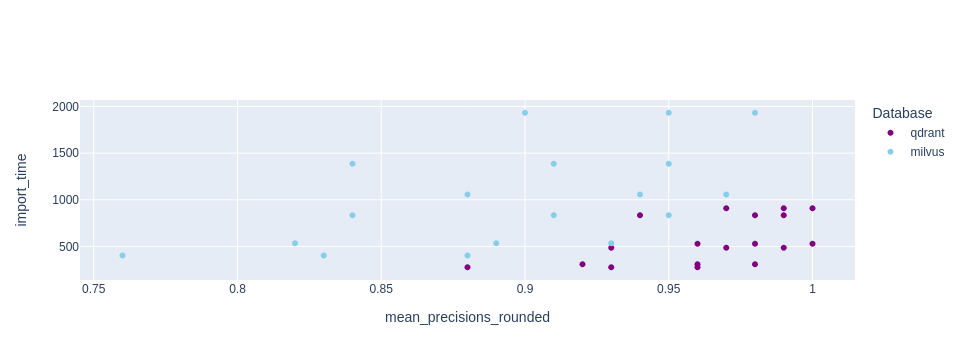



****************************************************************************************************
*********************** Dataset: random-match-keyword-100-angular-no-filters ***********************
****************************************************************************************************


*************************************** search parallel 100 ***************************************



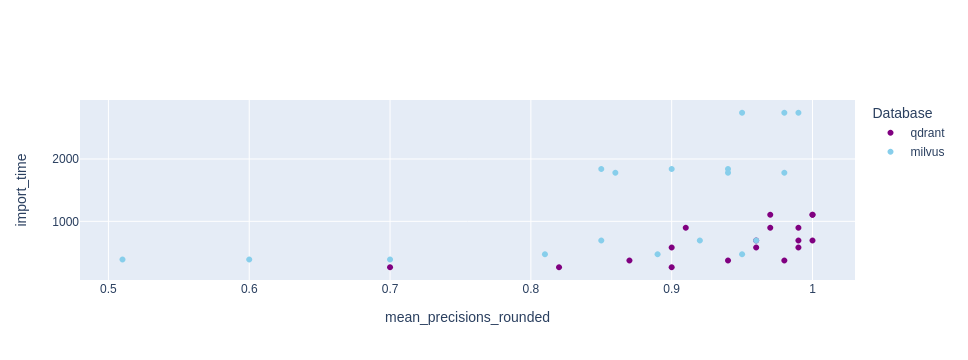



****************************************************************************************************
***************************** Dataset: h-and-m-2048-angular-no-filters *****************************
****************************************************************************************************


*************************************** search parallel 100 ***************************************



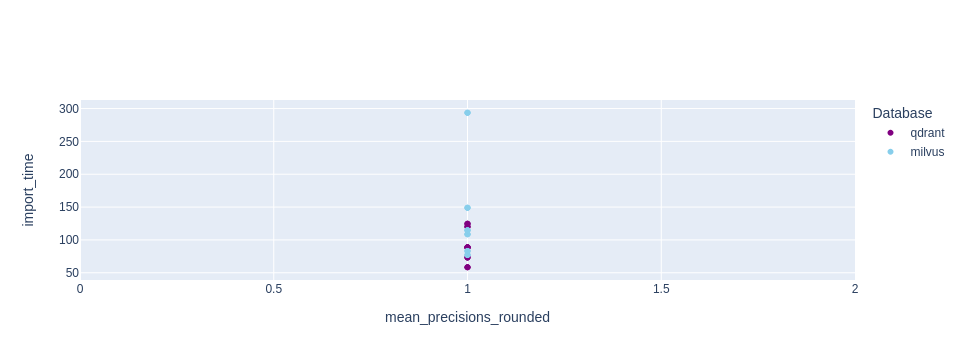



****************************************************************************************************
*********************************** Dataset: gist-960-euclidean ***********************************
****************************************************************************************************


*************************************** search parallel 100 ***************************************



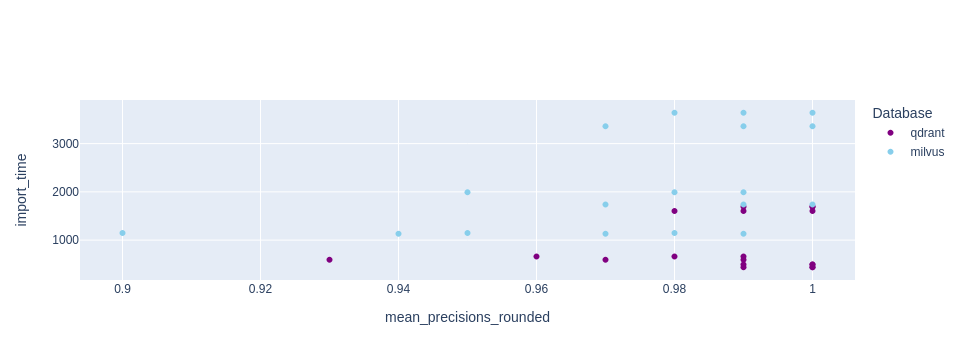

In [26]:
all_metrics = ['total_time', 'mean_time', 'p95_time', 'rps', 'upload_time', 'index_time', 'import_time']
selected_metrics = ['import_time']
for met in selected_metrics:
    print_h1(met, 'metric: ')
    plot_results_of_similar_precision(tested_datasets, selected_parallel = 100, metric=met)

### Observations
In this section, we examine engine configurations in groups of the same precision and then compare the following metrics for each dataset.
1. `total_time`:
    As expected, high precision requires more total query time for both databases.
    - **glove-100-angular**: For the same precision, Milvus requires total query time similar to the fastest configuration of Qdrant of this group. However, Qdrant has more models that achieve a high precision.
    - **random-match-keyword-100-angular-no-filters**:  In most precisions, Milvus requires less query time than the corresponding Qdrant configurations.
    - **h-and-m-2048-angular-no-filters**: Milvus is faster in query time for this dataset. Both DataBases achieve 100% precision in this dataset for the most configurations.
    - **gist-960-euclidean**: Milvus and Qdrant best configurations achieve similar total query time in this dataset.
2. `rps`:
    - **glove-100-angular**: Milvus achieves a bit higher rps than Qdrant
    - **random-match-keyword-100-angular-no-filters**:  Here again, Milvus achieves a higher rps than best configurations of Qdrant
    - **h-and-m-2048-angular-no-filters**:  Milvus achieves a clearly higher rps due to the fact that all configurations of the two databases perform the queries of this dataset with 1.0 precision
    - **gist-960-euclidean**: Here, Qdrant achieves a higher rps. This dataset uses euclidean distance metric, so, this should be also taken into account when comparing to the other datasets using cosine distance.
3. `import_time`:
    - **glove-100-angular**: The fastest Milvus model (concerning import time in a precision level) requires a little more import time than the slowest Qdrant Model but at least the double time than the fastest Qdrant Model
    - **random-match-keyword-100-angular-no-filters**:  Milvus is slower in this dataset concerning import time excluding some special occasions
    - **h-and-m-2048-angular-no-filters**: Milvus is slower again in this dataset
    - **gist-960-euclidean**: Here, Milvus has some fast configurations but they are still slower than fast Qdrant configurations.

Generally,
1. `total_time`: In most cases and precision levels, the best configuration of Qdrant requires similar or up to 20-40% more for query time.
2. `rps`: In most precision levels and cosine-distance datasets, Milvus performs more rps whereas in `gist-960-euclidean` (euclidean-distance) Qdrant performs more rps
3. `import_time`: Comparing the fastest Qdrant and Milvus configurations concerning import time for the same precision level, Milvus requires approximately the double time than Qdrant.

### Join similar precision results

In [19]:
# # merged_df is a join of a dataframes for Qdrant and Milvus data based on
# (Qdrant and Milvus have equal rounded mean_precisions in the same dataset)
merged_df = pd.merge(
    qdrant_search_df,                  # Left DataFrame
    milvus_search_df,                  # Right DataFrame
    left_on=['mean_precisions_rounded', 'dataset'],  # Keys in left DataFrame
    right_on=['mean_precisions_rounded', 'dataset'], # Keys in right DataFrame
    how='inner',                       # Type of join
    suffixes=('_qdrant', '_milvus')    # Custom suffixes for overlapping columns
)

# Sorting by 'dataset_name' (ascending) and 'metric_milvus' (descending)
merged_df = merged_df.sort_values(
    by=['dataset', 'mean_precisions_rounded'], 
    ascending=[True, False]  # Ascending for dataset_name, Descending for metric_milvus
)

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4940 entries, 4824 to 4759
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   m_qdrant                 4940 non-null   int64  
 1   ef_construct_qdrant      4940 non-null   int64  
 2   parallel_search_qdrant   4940 non-null   int64  
 3   ef_search_qdrant         4940 non-null   int64  
 4   dataset                  4940 non-null   object 
 5   total_time_qdrant        4940 non-null   float64
 6   mean_time_qdrant         4940 non-null   float64
 7   mean_precisions_qdrant   4940 non-null   float64
 8   std_time_qdrant          4940 non-null   float64
 9   min_time_qdrant          4940 non-null   float64
 10  max_time_qdrant          4940 non-null   float64
 11  rps_qdrant               4940 non-null   float64
 12  p95_time_qdrant          4940 non-null   float64
 13  p99_time_qdrant          4940 non-null   float64
 14  config_qdrant        

In [20]:
def show_joined_results_of_similar_precision(selected_datasets: list = None, selected_parallel: int = 100, metric: str = "total_time", precision: float = None) -> None:
    # selected_m = [16, 32, 64]                    # m: possible values [16, 32, 64]
    # selected_ef_construct = [128, 256, 512]      # ef_construct: possible values [128, 256, 512]
    # selected_ef_search = [64, 128, 256, 512]     # ef_search: possible values [64, 128, 256, 512] - 64 only for Qdrant
    
    global merged_df
    base_metric = 'mean_precisions_rounded'
    
    for dataset in selected_datasets:
        print_h1(dataset)
        print_h2(f"search parallel {selected_parallel}")
        
        filtered_df = merged_df[
            (merged_df['dataset'] == dataset) & 
            (merged_df['parallel_search_qdrant'] == selected_parallel) &
            (merged_df['parallel_search_milvus'] == selected_parallel) 
        ]
        # filter by precision if provided
        if precision: filtered_df = filtered_df[ (filtered_df['mean_precisions_rounded'] == precision) ]

        selected_columns = filtered_df[['dataset', base_metric, 'config_qdrant', f'{metric}_qdrant', 'config_milvus', f'{metric}_milvus']]
        display(selected_columns)

In [26]:
show_joined_results_of_similar_precision(tested_datasets, precision=0.99)



****************************************************************************************************
************************************ Dataset: glove-100-angular ************************************
****************************************************************************************************


*************************************** search parallel 100 ***************************************



,dataset,mean_precisions_rounded,config_qdrant,total_time_qdrant,config_milvus,total_time_milvus




****************************************************************************************************
*********************** Dataset: random-match-keyword-100-angular-no-filters ***********************
****************************************************************************************************


*************************************** search parallel 100 ***************************************



,dataset,mean_precisions_rounded,config_qdrant,total_time_qdrant,config_milvus,total_time_milvus
4927,random-match-keyword-100-angular-no-filters,0.99,qdrant-m-32-ef-256-parallel-100-ef-search-512,60.004322,milvus-m-64-ef-512-parallel-100-ef-search-512,42.804713
4931,random-match-keyword-100-angular-no-filters,0.99,qdrant-m-32-ef-512-parallel-100-ef-search-512,63.540944,milvus-m-64-ef-512-parallel-100-ef-search-512,42.804713
4935,random-match-keyword-100-angular-no-filters,0.99,qdrant-m-64-ef-256-parallel-100-ef-search-256,56.089397,milvus-m-64-ef-512-parallel-100-ef-search-512,42.804713




****************************************************************************************************
***************************** Dataset: h-and-m-2048-angular-no-filters *****************************
****************************************************************************************************


*************************************** search parallel 100 ***************************************



,dataset,mean_precisions_rounded,config_qdrant,total_time_qdrant,config_milvus,total_time_milvus




****************************************************************************************************
*********************************** Dataset: gist-960-euclidean ***********************************
****************************************************************************************************


*************************************** search parallel 100 ***************************************



,dataset,mean_precisions_rounded,config_qdrant,total_time_qdrant,config_milvus,total_time_milvus
4651,gist-960-euclidean,0.99,qdrant-m-16-ef-128-parallel-100-ef-search-512,7.416244,milvus-m-32-ef-128-parallel-100-ef-search-512,10.736340
4653,gist-960-euclidean,0.99,qdrant-m-16-ef-128-parallel-100-ef-search-512,7.416244,milvus-m-32-ef-256-parallel-100-ef-search-512,10.277726
4655,gist-960-euclidean,0.99,qdrant-m-16-ef-128-parallel-100-ef-search-512,7.416244,milvus-m-32-ef-512-parallel-100-ef-search-256,7.413355
4657,gist-960-euclidean,0.99,qdrant-m-16-ef-128-parallel-100-ef-search-512,7.416244,milvus-m-64-ef-256-parallel-100-ef-search-256,9.003764
4659,gist-960-euclidean,0.99,qdrant-m-16-ef-128-parallel-100-ef-search-512,7.416244,milvus-m-64-ef-512-parallel-100-ef-search-256,9.507221
4671,gist-960-euclidean,0.99,qdrant-m-32-ef-128-parallel-100-ef-search-512,9.095007,milvus-m-32-ef-128-parallel-100-ef-search-512,10.736340
4673,gist-960-euclidean,0.99,qdrant-m-32-ef-128-parallel-100-ef-search-512,9.095007,milvus-m-32-ef-256-parallel-100-ef-search-512,10.277726
4675,gist-960-euclidean,0.99,qdrant-m-32-ef-128-parallel-100-ef-search-512,9.095007,milvus-m-32-ef-512-parallel-100-ef-search-256,7.413355
4677,gist-960-euclidean,0.99,qdrant-m-32-ef-128-parallel-100-ef-search-512,9.095007,milvus-m-64-ef-256-parallel-100-ef-search-256,9.003764
4679,gist-960-euclidean,0.99,qdrant-m-32-ef-128-parallel-100-ef-search-512,9.095007,milvus-m-64-ef-512-parallel-100-ef-search-256,9.507221


### Union of similar precision results

In [29]:
def show_union_results_of_similar_precision(selected_datasets: list = None, selected_parallel: int = 100, metric: str = "total_time", precision: float = None) -> None:
    base_metric = 'mean_precisions_rounded'
    union_df = pd.concat([qdrant_search_df, milvus_search_df], axis=0)
    union_df = union_df.sort_values(
        by=['dataset', 'mean_precisions_rounded'], 
        ascending=[True, False]  # Ascending for dataset_name, Descending for metric_milvus
    )
    for dataset in selected_datasets:
        print_h1(dataset)
        print_h2(f"search parallel {selected_parallel}")
        filtered_df = union_df[
            (union_df['dataset'] == dataset) & 
            (union_df['parallel_search'] == selected_parallel) 
        ]
        # filter by precision if provided
        if precision: filtered_df = filtered_df[ (filtered_df['mean_precisions_rounded'] == precision) ]

        selected_columns = ['dataset', 'mean_precisions_rounded', 'config']
        display(filtered_df[selected_columns])

In [30]:
show_union_results_of_similar_precision(tested_datasets, precision = 0.99)



****************************************************************************************************
************************************ Dataset: glove-100-angular ************************************
****************************************************************************************************


*************************************** search parallel 100 ***************************************



,dataset,mean_precisions_rounded,config
199,glove-100-angular,0.99,qdrant-m-32-ef-256-parallel-100-ef-search-512
271,glove-100-angular,0.99,qdrant-m-32-ef-512-parallel-100-ef-search-512
406,glove-100-angular,0.99,qdrant-m-64-ef-512-parallel-100-ef-search-256




****************************************************************************************************
*********************** Dataset: random-match-keyword-100-angular-no-filters ***********************
****************************************************************************************************


*************************************** search parallel 100 ***************************************



,dataset,mean_precisions_rounded,config
206,random-match-keyword-100-angular-no-filters,0.99,qdrant-m-32-ef-256-parallel-100-ef-search-512
278,random-match-keyword-100-angular-no-filters,0.99,qdrant-m-32-ef-512-parallel-100-ef-search-512
341,random-match-keyword-100-angular-no-filters,0.99,qdrant-m-64-ef-256-parallel-100-ef-search-256
422,random-match-keyword-100-angular-no-filters,0.99,milvus-m-64-ef-512-parallel-100-ef-search-512




****************************************************************************************************
***************************** Dataset: h-and-m-2048-angular-no-filters *****************************
****************************************************************************************************


*************************************** search parallel 100 ***************************************



,dataset,mean_precisions_rounded,config




****************************************************************************************************
*********************************** Dataset: gist-960-euclidean ***********************************
****************************************************************************************************


*************************************** search parallel 100 ***************************************



,dataset,mean_precisions_rounded,config
54,gist-960-euclidean,0.99,qdrant-m-16-ef-128-parallel-100-ef-search-512
126,gist-960-euclidean,0.99,qdrant-m-32-ef-128-parallel-100-ef-search-512
180,gist-960-euclidean,0.99,qdrant-m-32-ef-256-parallel-100-ef-search-128
261,gist-960-euclidean,0.99,qdrant-m-32-ef-512-parallel-100-ef-search-256
324,gist-960-euclidean,0.99,qdrant-m-64-ef-256-parallel-100-ef-search-128
396,gist-960-euclidean,0.99,qdrant-m-64-ef-512-parallel-100-ef-search-128
126,gist-960-euclidean,0.99,milvus-m-32-ef-128-parallel-100-ef-search-512
198,gist-960-euclidean,0.99,milvus-m-32-ef-256-parallel-100-ef-search-512
261,gist-960-euclidean,0.99,milvus-m-32-ef-512-parallel-100-ef-search-256
333,gist-960-euclidean,0.99,milvus-m-64-ef-256-parallel-100-ef-search-256


# Filtered search benchmark

In [23]:
selected_datasets = ["h-and-m-2048-angular-no-filters", "h-and-m-2048-angular-filters"]
parallel_search = 100

## Regular Search

## Filter Search